# Alignment Demo

In this notebook the alignment of micro images is presented using pre-computed centroids from **[PlenoptiCam](https://github.com/hahnec/plenopticam)** similar to the procedure provided in [01_calib_demo.ipynb](./01_calib_demo.ipynb).

## Package and import prerequisites

In [1]:
import sys, os
print('Python v'+sys.version+'\n')

try:
    import plenopticam as pcam
except ImportError:
    !pip install plenopticam>=0.7.0
    import plenopticam as pcam
print('PlenoptiCam v'+pcam.__version__+'\n')

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib --upgrade
    import matplotlib.pyplot as plt
    
%matplotlib inline

Python v3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]

PlenoptiCam v0.7.0



## Image data acquisition
Available plenoptic photographs can be downloaded to the current folder ('./data') using the featured `DataDownloader` class, which is also used for extracting archived files.

In [2]:
loader = pcam.misc.DataDownloader()
loader.download_data(loader.opex_prep_url, fp='./data')
loader.extract_archive(archive_fn='./data/OpEx_data_prepared.zip')

Download skipped as OpEx_data_prepared.zip already exists


## Configuration of *PlenoptiCam*

Before running the process, configurations such as file paths need to be set, using the `PlenopticamConfig` class as follows

In [3]:
# instantiate config object and set image file paths and options
cfg = pcam.cfg.PlenopticamConfig()
cfg.default_values()
cfg.params[cfg.lfp_path] = './data/f197with4m11pxFinal.bmp'
cfg.params[cfg.cal_meta] = './data/f197with4m11pxf16Final.json'
cfg.params[cfg.ptc_leng] = 9

# load calibration data
cfg.load_cal_data()

# instantiate status object to display processing progress
sta = pcam.misc.PlenopticamStatus()

## Reading a plenoptic photograph

Image files of the following extenions ('bmp', 'png', 'jpg', 'jpeg') can be loaded using the `load_img_file` procedure which is part of the featured `misc` module.

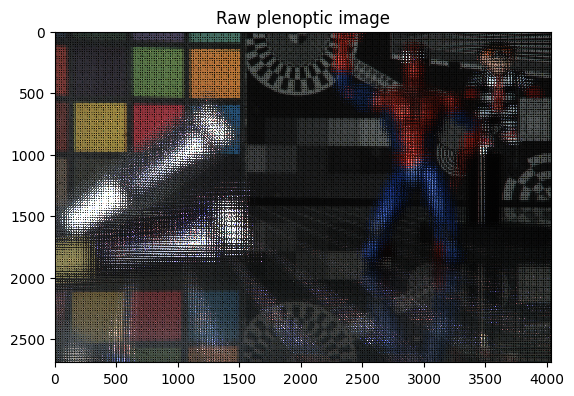

In [4]:
lfp_img = pcam.misc.load_img_file(cfg.params[cfg.lfp_path])

plt.figure()
plt.imshow(lfp_img, interpolation='none')
plt.grid(False)
plt.title('Raw plenoptic image')
plt.show()

Now the image data is read and stored in the `lfp_img` variable.

## Micro image alignment

Once the plenoptic image is present, alignment of micro images is conducted with the `LfpResampler` class at an abstract level. Results can be inspected in the plots below.

In [5]:
if cfg.lfpimg:
    # hot pixel correction
    obj = pcam.lfp_aligner.CfaOutliers(bay_img=lfp_img, cfg=cfg, sta=sta)
    obj.rectify_candidates_bayer(n=9, sig_lev=2.5)
    self._lfp_img = obj.bay_img
    del obj

if cfg.params[cfg.opt_vign] and wht_img is not None:
    # apply de-vignetting
    obj = pcam.lfp_aligner.LfpDevignetter(lfp_img=lfp_img, wht_img=wht_img, cfg=cfg, sta=sta)
    obj.main()
    lfp_img = obj.lfp_img
    wht_img = obj.wht_img
    del obj

if cfg.lfpimg and len(lfp_img.shape) == 2:
    # perform color filter array management and obtain rgb image
    cfa_obj = pcam.lfp_aligner.CfaProcessor(bay_img=self._lfp_img, wht_img=self._wht_img, cfg=cfg, sta=sta)
    cfa_obj.main()
    self._lfp_img = cfa_obj.rgb_img
    del cfa_obj

if cfg.params[cfg.opt_rota] and lfp_img is not None:
    # de-rotate centroids
    obj = pcam.lfp_aligner.LfpRotator(lfp_img, cfg.calibs[cfg.mic_list], rad=None, cfg=cfg, sta=sta)
    obj.main()
    lfp_img, cfg.calibs[cfg.mic_list] = obj.lfp_img, obj.centroids
    del obj

# interpolate each micro image with its MIC as the center with consistent micro image size
obj = pcam.lfp_aligner.LfpResampler(lfp_img=lfp_img, cfg=cfg, sta=sta, method='linear')
obj.main()
lfp_img_align = obj.lfp_out
del obj


 Light-field alignment
 Progress: Finished 


 Save aligned light-field

 Potential data loss as directory already exists.
 Progress: Finished 



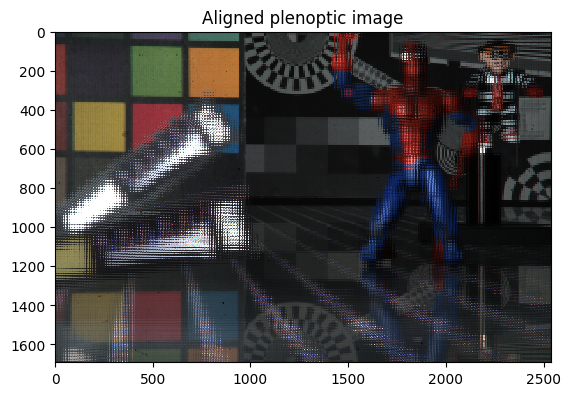

In [6]:
plt.figure()
plt.imshow(lfp_img_align/lfp_img_align.max(), interpolation='none')
plt.grid(False)
plt.title('Aligned plenoptic image')
plt.show()